# Example of Tim's work in back-testing
***
## What is this?
While I was a grad student at the Kelley School of Business I headed up a team project to design a python program for a "Programming and Finance" elective. Our initial project proposal was terrible... We were forced to scrap that project. The team collectively was interested in back-testing and settled instead for exploring what it took to write a strategy backtester from scratch. The scope of this project was thus to simply demonstrate what skills and knowledge are necessary to carry out a bare-bones backtest. In laying out a rough skeletal framework we can also consider how to move from the general to the specific. 


## The second (silly) goal of this project:
>"... all models are wrong: the practical question is how wrong do they have to be to not be useful." - Box and Draper (1987, pg 74).

The fact that modeling is both a mathematical science and an art means that humanity will always be beholden to model risk. Finance knows this all too well especially when modeling risk. There is a poetic irony that the models we use to measure risk carry their own risks. 

Why do I mention this? I was fortunate enough to have been a student of Arkadev Chatterjea who taught me risk management. In one his lessons he presented the following: 
* We cannot truly rely on models.
* But, if we forgo the models altogether then how are we to make informed decisions?

Professor Chatterjea would go on to stress that this situation is not the real issue at hand and dwelling on it will get us nowhere. The reality is not binary such that we either trust the models or we stop using them altogether. In actuallity, very crude models that only half-heartedly approximate reality can nevertheless be useful in certain descision making contexts. What is important to consider are the assumptions that go into the model.

So if that is the case what happens when we go to the extreme and consider assumptions that make zero sense? What would we see if a strategy employed an arbitrary assumption? What if we selected arbitrary assumptions for all but one assumption? How silly would it be to design a an arbitrary portfolio strategy, see where it goes.

So as a side goal of the project my team backtested a portfolio strategy built on terrible assumptions. Our goal on our very first try was to create an alpha earning portfolio by doing everything we could to avoid it being a respectable strategy. It would be the antithesis of a serious portfolio strategy, on par with that of finding a great strategy by looking long enough at historical data or that of a monkey on Wallstreet.  We therefor characterized a well-thought-out alpha earning portfolio strategy to be something like: 

* Logical with a well defined strategy.
* Is in agreement with the investor's preferences on risk and timing.
* Can be understood by the investor.

If we avoid these characteristics our strategy will, by definition, be anything but well-thought-out. So it should follow that the assumptions are poor in quality and substance and could not be logically justified under critical analysis. This is what we came up with.

****
### The strategy:
##### Generate a random univere of stocks weighted predominately towards a blend of mid and small cap stocks and with a remainder of roughly 20% to 25% large cap. Restrict all future portfolio allocations to this universe of stocks. No shorting is allowed. Take *exactly* the previous 2 years of daily adjusted closing prices and optimize the allocation on this trading data such that the Sharpe ratio is maximized. Every quarter re-optimze the portfolio using  *exactly* the previous 2 years of trading. Rinse and repeat.
**** 

That's one absurd strategy if I've ever seen one. Why does the investor limit themselves to a small universe of stocks? The reason is because the better assumption would be he can access all available assets, and we can't have that. Requiring the observaation time frame to be arbitrary means it's outside the investors control to make judgement calls on whether the observed data is statistically representative. The investor gets zero say in the risk they are exposed to, just that the reward to risk will be maximized. And restricting the re-balancing to scheduled dates means no timely re-balancings may occur. Truly, the cards are stacked against the investor. Therefor we have achieved an insane strategy. It must follow that all else is better than this strategy.

It shouldn't come as a suprise the portfolio could not achieve any alpha returns.

## One last note:
While this project was team based, the code you see here is entirely my own. My teammates contribution was that of brainstorming approaches and endlessly testing my code. That's not to make light of their efforts nor their abilites. Their contributions were invaluable, but they ultimately turned to me as team leader to build out the code. 


In [1]:
import time, pandas as pd, numpy as np, scipy.optimize as sciop
import pandas_datareader as pdr
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.interpolate as sci
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', 50)
from IPython.display import clear_output

# Generating a universe of stocks:
Given the strategy we elected to draw from the Russell 3000. We drew stocks using the following criteria. For each decile of Russell 3000 we selected the first 5 companies of each decile. We dropped the stocks that had not traded during the full period of observation (that is, recent IPOs). Additionally exclud the first decile altogether. What remains is a portfolio of a handful of large cap stocks and a blend of mid and small cap stocks. In total there were 37 stocks in our universe to build a portfolio from. The stocks are: 

In [2]:
comp_list = ['LOW','BKNG','DD','AMT','GE','RSG','SNPS','VEEV','CBS','DXC','BG','LAMR','KIM','HELE','SIGI','S','FHB','CRS','AIMC','TEX','FORM','CSGS','AROC','ATRA','ANDE','TELL','GFF','LMNX','ACLS','GOOD','AKBA','RILY','TLRA','LAND','FBMS','NKSH','TWIN']

Given the universe of stocks and where they were drawn from we opted to benchmark against the Russell 3000.

##### Commentary:
The described approach is hardly random and incredibly problematic. It is likely the case that the large cap stocks -even though there are a handful of them - will drive the majority of performance (that will be important later). Additionally,  If only I knew at the time how to build a sampler... like this one I built for the Russell 2000.
```Python
rus2000 = pd.read_excel('russell_2000_stock_tickers.xlsx')
selected_seed = 1234
rus2_sample = rus2000.sample(n=50, random_state = selected_seed)
ticker_list = list(rus2_sample.Ticker)
```
This would have been much easier...


### Building the Main DataFrame
This following DataFrame, `df`, contains the adjusted closing prices of the stocks in our universe. Once this  dataframe is constructed, the program has all the data it needs. The dataframe may take some time to complete. 

##### Commentary
The code unfortunately must retrieve the necessary data alongside other pricing data that won't be used here. All that hard work gets dumped... :(

In [4]:
print("Building Main DataFrame")
df = pdr.get_data_yahoo(comp_list, '2015', '2020', interval = 'd')  # df starts with multindex 
df = df.loc[:, pd.IndexSlice['Adj Close', :]] # overwrite so each stock only has adjusted close
df.columns = df.columns.levels[1] # get rid of multindex
print("Done!")

Building Main DataFrame
Done!


#### Commentary
Since this demonstration isn't that computationally intensive and doesn't take very long to download the data I rarely opt to save the dataframe. Still, if you need to save the data just add the following to pickle it:
```Python
df.to_pickle('silly_strat_dataframe.pkl')
```
To load the data later add the following:
```Python
df = pd.read_pickle('silly_strat_dataframe.pkl')
```

## Some info on the dataframe

Below is a quick look at what data we are working with. Notice that these are all adjusted closing prices. The number

In [82]:
print("Maximum number of observations: {}".format(df.count().max()))
print("Minimum number of observations: {}".format(df.count().min()))
df.head(10)
df.tail()

Maximum number of observations: 1229
Minimum number of observations: 1229


Symbols,ACLS,AIMC,AKBA,AMT,ANDE,AROC,ATRA,BG,BKNG,CBS,CRS,CSGS,DD,DXC,FBMS,FHB,FORM,GE,GFF,GOOD,HELE,KIM,LAMR,LAND,LMNX,LOW,NKSH,RILY,RSG,S,SIGI,SNPS,TELL,TEX,TLRA,TWIN,VEEV
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,10.20,26.016121,11.50,90.685654,48.438496,26.169426,26.700001,79.203506,1142.060059,51.564766,43.914070,22.245516,58.773994,21.410477,13.919315,627.846252,8.31,20.850058,11.801721,11.709212,64.790001,19.397480,42.702259,8.350938,18.248041,61.919804,26.521982,8.900008,36.206093,4.24,24.898741,43.099998,7.36,26.873728,2.89,18.602312,26.230000
2015-01-05,10.00,25.067421,11.09,89.375458,48.147846,25.318903,27.780001,77.596153,1097.579956,51.065964,41.540085,21.763500,56.956245,20.977194,13.765296,621.522461,8.45,20.467335,11.677115,11.743076,63.330002,19.572720,42.130466,8.102253,18.151079,60.438099,25.748568,8.371297,36.000828,4.21,24.526976,42.540001,6.64,25.135670,2.83,17.934141,26.230000
2015-01-06,9.60,24.492735,11.06,89.138893,47.185062,24.421118,25.889999,76.866318,1079.959961,50.058945,40.724319,21.708931,56.040916,21.031355,13.505394,623.329224,8.01,20.026371,11.525812,11.702438,63.360001,19.687000,42.456066,8.182470,17.908678,60.575279,26.061411,8.371297,36.125778,4.19,24.071566,42.160000,6.80,24.323320,2.65,17.362804,27.120001
2015-01-07,9.72,24.392391,11.43,90.076050,47.730034,24.397493,26.000000,77.265999,1069.569946,49.983646,40.705990,22.100000,55.950676,21.183683,13.669037,630.556274,8.13,20.034693,11.543612,11.763390,64.750000,20.197460,43.091400,8.375001,19.081902,62.377090,25.913679,8.811888,36.000828,4.22,24.155214,42.209999,7.20,24.077728,2.54,17.682367,27.170000
2015-01-08,9.92,24.666056,11.10,90.913109,45.177776,24.759756,26.110001,78.682205,1082.849976,50.576580,40.476833,22.309181,57.342991,21.424021,13.669037,645.913635,8.45,20.275972,11.748318,11.776936,66.580002,20.266031,43.512306,8.495335,19.217649,63.694145,26.548048,8.811888,36.331020,4.16,24.870855,42.860001,7.28,24.238306,2.59,17.808252,28.389999
2015-01-09,10.08,24.082243,11.50,90.449081,44.115086,24.239990,25.370001,77.726463,1051.959961,51.348301,39.514412,22.554733,57.252758,21.762524,14.054078,632.362915,8.26,19.993092,11.837320,11.749845,74.629997,20.220312,43.432892,8.423136,18.907373,62.495987,25.896296,8.591592,36.072224,4.13,24.610615,42.930000,7.20,23.378725,2.55,17.817934,28.790001
2015-01-12,9.80,23.261259,11.43,90.057854,43.588299,22.956324,27.459999,77.187790,1039.979980,51.621243,39.129433,22.763910,56.917568,21.390169,13.678665,634.169739,8.02,19.951487,11.881821,11.743076,74.169998,20.342216,43.258171,8.286761,18.994642,62.056957,25.522629,8.591592,35.831272,4.13,24.657093,42.500000,6.88,22.538034,2.44,17.382172,29.120001
2015-01-13,9.60,23.243008,10.96,89.056999,44.233166,22.491690,25.719999,78.091377,1037.819946,52.327084,39.211929,23.064037,56.221413,21.373241,13.669037,637.783264,8.01,19.851652,12.006426,11.770166,74.639999,20.433645,43.448780,8.543462,19.266134,62.066124,25.713810,8.811888,35.759861,4.15,24.796505,42.400002,6.64,22.027958,2.42,17.033564,29.090000
2015-01-14,9.60,23.315989,10.99,88.492889,42.543762,22.617693,26.730000,78.047951,1035.670044,51.263603,38.441994,23.027657,55.989357,21.478182,13.669037,637.783264,7.87,19.785088,11.997526,11.776936,74.239998,20.776485,43.647316,8.695886,18.810413,61.636242,25.548700,8.371297,35.733093,4.13,24.629211,42.230000,6.64,21.810699,2.36,16.830202,28.719999


Symbols,ACLS,AIMC,AKBA,AMT,ANDE,AROC,ATRA,BG,BKNG,CBS,CRS,CSGS,DD,DXC,FBMS,FHB,FORM,GE,GFF,GOOD,HELE,KIM,LAMR,LAND,LMNX,LOW,NKSH,RILY,RSG,S,SIGI,SNPS,TELL,TEX,TLRA,TWIN,VEEV
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-12,22.49,33.279999,3.3300,206.750000,23.190001,9.000,13.000,55.217567,1875.839966,37.759998,52.950001,56.150002,72.599998,35.250000,33.400002,28.850000,22.690001,11.42,21.709999,22.680000,155.339996,20.730000,82.000000,12.035419,20.030001,114.320000,43.310001,28.220001,86.019997,5.87,67.978951,138.889999,7.390,30.320000,7.500,11.04,146.679993
2019-11-13,22.52,33.299999,3.3100,210.320007,22.860001,8.760,13.105,54.702255,1859.089966,36.849998,52.360001,56.169998,69.949997,34.599998,33.259998,28.639999,22.690001,11.29,21.730000,22.750000,154.630005,21.049999,81.690002,12.085234,19.920000,112.849998,43.259998,28.459999,86.820000,6.06,67.669998,139.199997,7.640,29.420000,7.440,10.84,148.309998
2019-11-14,22.16,32.990002,3.2200,211.800003,23.280001,8.620,13.205,54.950001,1865.550049,37.630001,51.810001,56.779999,70.000000,35.830002,33.040001,28.719999,22.709999,11.29,24.969999,22.879999,153.830002,21.559999,82.410004,12.095197,19.820000,114.540001,43.299999,28.450001,87.129997,5.87,67.500000,138.130005,7.970,28.870001,7.340,10.56,148.690002
2019-11-15,22.74,33.580002,3.3600,213.369995,23.150000,8.760,13.195,56.189999,1848.819946,38.570000,52.950001,57.020000,67.639999,37.230000,33.000000,28.450001,23.219999,11.52,22.450001,22.959999,153.339996,21.530001,83.459999,12.040400,20.160000,115.519997,43.279999,28.219999,86.910004,5.83,66.949997,139.710007,7.750,29.190001,7.590,10.60,153.160004
2019-11-18,22.65,33.599998,3.1689,214.145004,23.240000,8.545,13.760,54.740002,1835.479980,39.145302,52.830002,57.549999,66.815002,36.985298,33.049999,28.334999,23.094999,11.40,22.525000,22.660000,156.160004,21.719999,83.139999,11.940000,19.850000,115.144997,43.740002,28.389999,87.088501,5.86,66.900002,138.839996,7.665,28.514999,7.835,10.62,151.574997


### Convert to Log Returns

In [28]:
df_log_returns = np.log(df / df.shift(1))

### Getting a sense of the data
First, double check to see if the conversion to log returns worked. Then, test to see if we can produce a slice of the `log_returns` dataframe. This is all just for exploration.

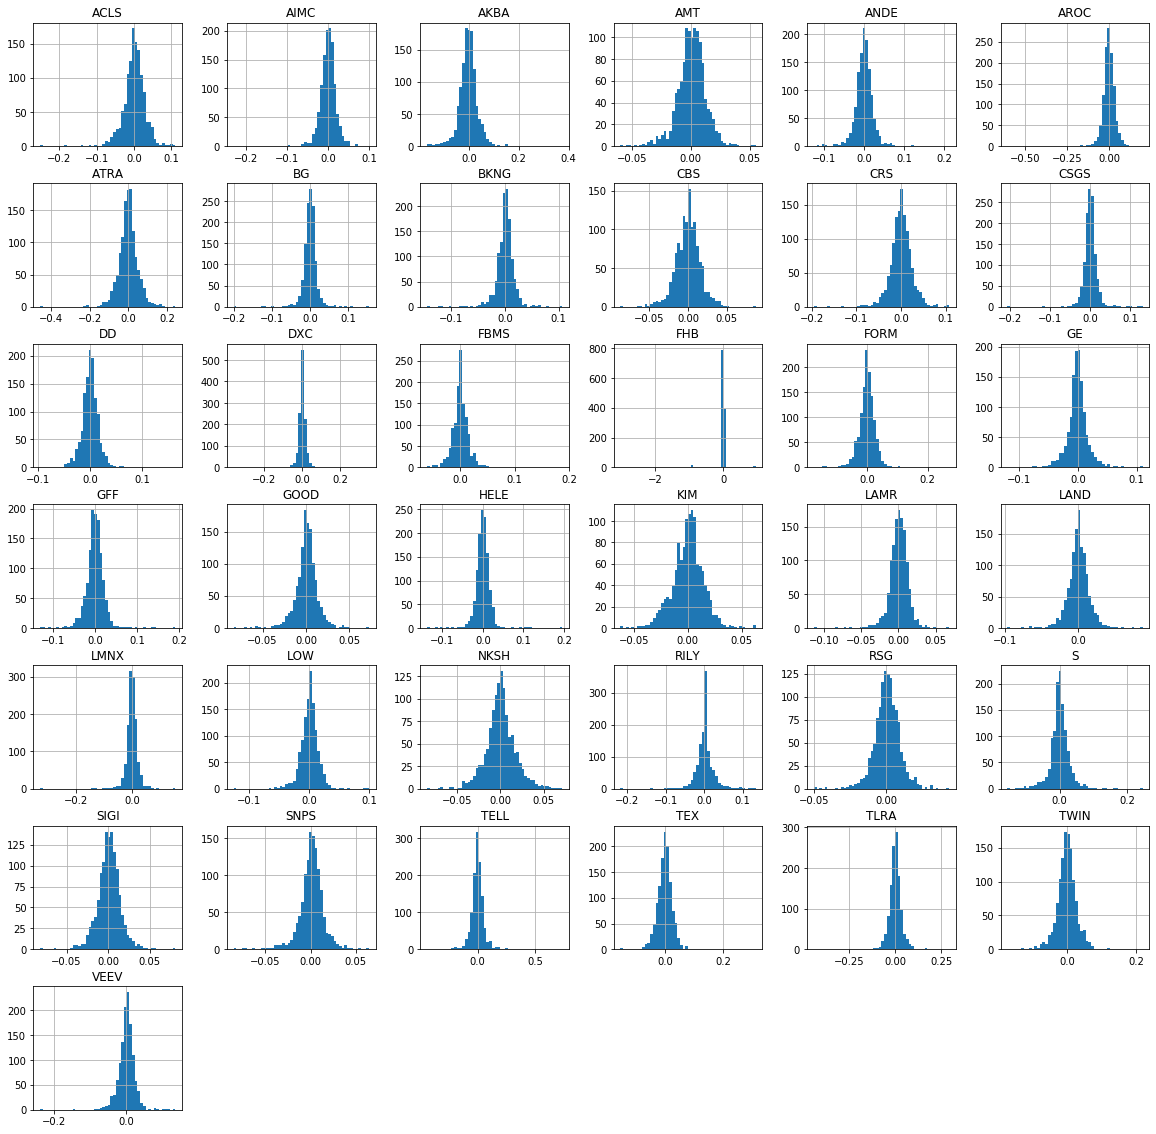

In [30]:
df_log_returns.hist(bins = 50, figsize = (20,20));

The above return distributions for each stock look interesting.

### Examining a historical data slice

In [39]:
df_slice_test = df_log_returns.loc['2015':'2016']

print("Start of a historical data slice")
df_slice_test.head()
print("Tail end of a historical data slice")
df_slice_test.tail()

print("Expected Returns")
mean_returns_test = df_slice_test.mean()
mean_returns_test * 252

Start of a historical data slice


Symbols,ACLS,AIMC,AKBA,AMT,ANDE,AROC,ATRA,BG,BKNG,CBS,CRS,CSGS,DD,DXC,FBMS,FHB,FORM,GE,GFF,GOOD,HELE,KIM,LAMR,LAND,LMNX,LOW,NKSH,RILY,RSG,S,SIGI,SNPS,TELL,TEX,TLRA,TWIN,VEEV
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.019803,-0.037147,-0.036303,-0.014553,-0.006018,-0.033041,0.039653,-0.020503,-0.039726,-0.009720,-0.055576,-0.021906,-0.031416,-0.020445,-0.011127,-0.010123,0.016707,-0.018527,-0.010614,0.002888,-0.022792,0.008994,-0.013481,-0.030232,-0.005328,-0.024220,-0.029595,-0.061243,-0.005685,-0.007101,-0.015044,-0.013078,-0.102948,-0.066861,-0.020980,-0.036580,0.000000
2015-01-06,-0.040822,-0.023192,-0.002709,-0.002650,-0.020199,-0.036103,-0.070460,-0.009450,-0.016184,-0.019917,-0.019833,-0.002511,-0.016201,0.002579,-0.019061,0.002903,-0.053476,-0.021780,-0.013042,-0.003467,0.000474,0.005822,0.007699,0.009852,-0.013445,0.002267,0.012077,0.000000,0.003465,-0.004762,-0.018742,-0.008973,0.023811,-0.032852,-0.065717,-0.032376,0.033368
2015-01-07,0.012423,-0.004105,0.032906,0.010459,0.011483,-0.000968,0.004240,0.005186,-0.009667,-0.001505,-0.000450,0.017854,-0.001612,0.007217,0.012044,0.011528,0.014870,0.000415,0.001543,0.005195,0.021701,0.025598,0.014854,0.023257,0.063455,0.029311,-0.005685,0.051293,-0.003465,0.007134,0.003469,0.001185,0.057158,-0.010148,-0.042396,0.018238,0.001842
2015-01-08,0.020367,0.011157,-0.029296,0.009250,-0.054956,0.014739,0.004222,0.018163,0.012340,0.011793,-0.005645,0.009421,0.024580,0.011282,0.000000,0.024063,0.038605,0.011971,0.017578,0.001151,0.027871,0.003389,0.009720,0.014266,0.007089,0.020895,0.024185,0.000000,0.009130,-0.014320,0.029196,0.015282,0.011050,0.006647,0.019494,0.007094,0.043924


Tail end of a historical data slice


Symbols,ACLS,AIMC,AKBA,AMT,ANDE,AROC,ATRA,BG,BKNG,CBS,CRS,CSGS,DD,DXC,FBMS,FHB,FORM,GE,GFF,GOOD,HELE,KIM,LAMR,LAND,LMNX,LOW,NKSH,RILY,RSG,S,SIGI,SNPS,TELL,TEX,TLRA,TWIN,VEEV
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-23,0.010657,0.004013,0.049309,0.000094,0.013668,0.033648,0.076322,-0.000420,0.003275,0.002632,-0.004825,0.003688,0.000055,0.003455,0.023153,-0.002566,0.021787,0.001884,0.003831,0.010901,0.008309,-0.004777,0.004990,-0.010909,0.006789,-0.009772,0.008182,0.002635,0.000698,0.000000,0.002294,0.005874,-0.035204,0.007782,0.019418,-0.011345,0.002166
2016-12-27,0.010545,0.000000,-0.031627,0.002449,-0.002265,0.014599,-0.032470,0.007948,0.004846,0.002780,0.012549,0.005710,-0.000171,0.003444,0.000000,0.004557,0.029726,0.000627,0.015181,0.001547,0.009997,-0.000798,-0.009563,-0.001830,-0.004845,-0.000969,0.003486,0.013072,0.000871,0.022107,-0.005744,0.001505,0.070223,0.002168,0.007663,0.028451,0.012185
2016-12-28,-0.014085,-0.018868,0.002917,-0.004243,0.001133,-0.048247,-0.030153,-0.013845,-0.008716,-0.005412,-0.017666,-0.012481,-0.008941,-0.024357,-0.015972,-0.003986,-0.047118,-0.006289,0.000000,0.000000,-0.006457,-0.013266,-0.002961,0.013642,-0.010252,-0.009180,0.008088,0.000000,-0.001569,0.003446,-0.010423,-0.010582,0.147477,-0.009638,-0.050892,-0.019764,-0.019423
2016-12-29,0.024520,0.014855,0.005808,0.005183,-0.002048,0.015095,-0.027588,-0.002538,-0.000203,0.000000,-0.004601,0.004519,-0.008325,0.001843,-0.019874,-0.003429,-0.008811,0.000315,-0.011364,0.017881,0.005286,0.013816,0.000741,0.002706,-0.000491,-0.003219,0.025001,-0.007823,0.002628,0.010268,0.005804,0.003371,-0.068681,0.001873,0.000000,-0.005337,-0.005341
2016-12-30,0.006897,-0.010782,0.004815,-0.006696,0.018059,-0.011300,-0.007018,0.019711,-0.009572,-0.013737,-0.018897,-0.008026,-0.003489,-0.002490,0.003643,-0.003154,-0.008889,-0.003475,-0.001906,0.017566,-0.010601,0.015219,-0.003859,0.012534,-0.006897,-0.003088,-0.025001,-0.034624,-0.001751,-0.045278,-0.003478,-0.009469,0.051059,-0.016982,0.000000,-0.023690,-0.009293


Expected Returns


Symbols
ACLS    0.177955
AIMC    0.150492
AKBA   -0.049889
AMT     0.049162
ANDE   -0.069173
AROC   -0.414954
ATRA   -0.316338
BG     -0.091944
BKNG    0.125121
CBS     0.086691
CRS    -0.121173
CSGS    0.361838
DD      0.138654
DXC     0.422248
FBMS    0.330862
FHB    -1.496589
FORM    0.149524
GE      0.148624
GFF     0.352184
GOOD    0.166211
HELE    0.132768
KIM     0.036922
LAMR    0.160312
LAND    0.086159
LMNX    0.036195
LOW     0.040477
NKSH    0.211649
RILY    0.326827
RSG     0.200309
S       0.343705
SIGI    0.255615
SNPS    0.156129
TELL    0.212576
TEX     0.062806
TLRA   -0.074635
TWIN   -0.121373
VEEV    0.220099
dtype: float64

## What would the covariance matrix for the historical slice look like? What about the correlation matrix?

In [35]:
df_slice_test.cov()*252
df_slice_test.corr()

Symbols,ACLS,AIMC,AKBA,AMT,ANDE,AROC,ATRA,BG,BKNG,CBS,CRS,CSGS,DD,DXC,FBMS,FHB,FORM,GE,GFF,GOOD,HELE,KIM,LAMR,LAND,LMNX,LOW,NKSH,RILY,RSG,S,SIGI,SNPS,TELL,TEX,TLRA,TWIN,VEEV
Symbols,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACLS,0.229610,0.042072,0.038353,0.021258,0.053366,0.076254,0.065656,0.009797,0.040407,0.028969,0.048245,0.002944,0.031814,0.041262,0.002952,0.097489,0.062111,0.027452,0.032640,0.024081,0.030171,0.016018,0.021358,0.010930,0.034491,0.031296,0.032367,0.007432,0.013422,0.032307,0.036220,0.032315,0.022873,0.060951,0.049436,0.051351,0.044665
AIMC,0.042072,0.069768,0.024519,0.014788,0.037756,0.066693,0.041648,0.014914,0.026295,0.025837,0.055766,0.026584,0.028578,0.029608,0.000443,-0.009658,0.037496,0.021269,0.033857,0.017556,0.020409,0.015271,0.017087,0.013522,0.022604,0.019980,0.024290,0.010335,0.012429,0.042434,0.025181,0.021914,0.003479,0.056387,0.029853,0.047448,0.031532
AKBA,0.038353,0.024519,0.513995,0.008792,0.034330,0.079694,0.171481,0.013699,0.047289,0.032514,0.047896,0.018272,0.018296,0.032441,0.003426,0.110149,0.044005,0.020837,0.026166,0.016156,0.040581,0.009910,0.027922,0.027911,0.059995,0.022546,0.027962,0.008005,0.007534,0.036927,0.022471,0.023995,0.082474,0.047621,0.083080,0.040758,0.065853
AMT,0.021258,0.014788,0.008792,0.042288,0.026883,0.051543,0.012737,0.014928,0.021829,0.019921,0.024225,0.013459,0.018590,0.022811,0.001999,0.062581,0.016586,0.018483,0.015054,0.020775,0.014141,0.026332,0.019594,0.012489,0.014755,0.018797,0.009700,0.007123,0.014804,0.029411,0.016563,0.017305,0.017744,0.022509,0.015889,0.017184,0.018001
ANDE,0.053366,0.037756,0.034330,0.026883,0.172240,0.134006,0.058156,0.043281,0.024642,0.033505,0.063309,0.024980,0.033485,0.037215,-0.002466,0.031405,0.040771,0.027564,0.031347,0.018429,0.022188,0.017408,0.016531,0.010212,0.021050,0.027144,0.027400,0.007268,0.017628,0.053962,0.022620,0.026433,0.071892,0.051004,0.027606,0.052683,0.043741
AROC,0.076254,0.066693,0.079694,0.051543,0.134006,0.746668,0.091640,0.058834,0.053429,0.075524,0.148052,0.049943,0.075406,0.067913,-0.013850,-0.120682,0.067472,0.052328,0.056073,0.035825,0.044248,0.027114,0.038191,0.026330,0.054890,0.035973,0.039146,0.022210,0.023949,0.116567,0.028893,0.042763,0.194212,0.117416,0.047708,0.121890,0.083174
ATRA,0.065656,0.041648,0.171481,0.012737,0.058156,0.091640,0.828908,0.030377,0.044026,0.044346,0.096509,0.026430,0.040556,0.043749,0.006012,-0.162438,0.059936,0.029466,0.058925,0.012682,0.042773,0.021543,0.033809,0.016517,0.083639,0.028713,0.044126,0.019666,0.013800,0.071498,0.022740,0.042128,-0.007425,0.056068,0.117276,0.052280,0.073601
BG,0.009797,0.014914,0.013699,0.014928,0.043281,0.058834,0.030377,0.090120,0.009865,0.013136,0.033149,0.014819,0.022942,0.018025,0.004509,0.030404,0.014137,0.019570,0.012684,0.011773,0.012576,0.014050,0.015033,0.005928,0.010651,0.014155,0.013415,0.000406,0.010291,0.035811,0.013995,0.012746,0.036139,0.021998,0.012315,0.020515,0.017319
BKNG,0.040407,0.026295,0.047289,0.021829,0.024642,0.053429,0.044026,0.009865,0.080635,0.025729,0.039142,0.018173,0.027654,0.023393,0.006461,-0.014420,0.027702,0.024940,0.021814,0.017581,0.022343,0.016118,0.018909,0.013748,0.023511,0.022607,0.018754,0.008390,0.014509,0.045900,0.022323,0.025273,0.026574,0.037533,0.027332,0.028820,0.033306


Symbols,ACLS,AIMC,AKBA,AMT,ANDE,AROC,ATRA,BG,BKNG,CBS,CRS,CSGS,DD,DXC,FBMS,FHB,FORM,GE,GFF,GOOD,HELE,KIM,LAMR,LAND,LMNX,LOW,NKSH,RILY,RSG,S,SIGI,SNPS,TELL,TEX,TLRA,TWIN,VEEV
Symbols,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACLS,1.000000,0.332409,0.111640,0.215736,0.268352,0.184163,0.150496,0.068107,0.296964,0.247292,0.226649,0.021770,0.263472,0.240293,0.019950,0.046134,0.292451,0.290847,0.258934,0.225943,0.227253,0.160750,0.219480,0.092578,0.216089,0.305960,0.274734,0.035949,0.187158,0.118091,0.334067,0.341506,0.037408,0.246108,0.201875,0.228963,0.247002
AIMC,0.332409,1.000000,0.129476,0.272248,0.344421,0.292206,0.173185,0.188080,0.350577,0.400107,0.475265,0.356594,0.429346,0.312798,0.005429,-0.008292,0.320284,0.408804,0.487249,0.298824,0.278873,0.278027,0.318553,0.207777,0.256912,0.354349,0.374030,0.090686,0.314417,0.281389,0.421321,0.420114,0.010323,0.413036,0.221153,0.383799,0.316340
AKBA,0.111640,0.129476,1.000000,0.059635,0.115380,0.128641,0.262714,0.063649,0.232282,0.185509,0.150391,0.090298,0.101272,0.126272,0.015474,0.034839,0.138486,0.147554,0.138734,0.101312,0.204298,0.066475,0.191778,0.158006,0.251223,0.147321,0.158629,0.025878,0.070218,0.090217,0.138521,0.169484,0.090153,0.128517,0.226752,0.121465,0.243403
AMT,0.215736,0.272248,0.059635,1.000000,0.314991,0.290066,0.068030,0.241820,0.373816,0.396255,0.265192,0.231900,0.358735,0.309542,0.031480,0.069007,0.181979,0.456313,0.278274,0.454206,0.248184,0.615761,0.469199,0.246477,0.215404,0.428207,0.191844,0.080284,0.481017,0.250506,0.355961,0.426140,0.067623,0.211778,0.151185,0.178536,0.231958
ANDE,0.268352,0.344421,0.115380,0.314991,1.000000,0.373674,0.153913,0.347391,0.209101,0.330227,0.343396,0.213263,0.320176,0.250230,-0.019246,0.017159,0.221650,0.337180,0.287121,0.199640,0.192962,0.201710,0.196137,0.099869,0.152267,0.306391,0.268526,0.040586,0.283811,0.227744,0.240885,0.322530,0.135754,0.237783,0.130159,0.271215,0.279285
AROC,0.184163,0.292206,0.128641,0.290066,0.373674,1.000000,0.116484,0.226804,0.217749,0.357509,0.385700,0.204785,0.346299,0.219320,-0.051908,-0.031669,0.176174,0.307439,0.246673,0.186398,0.184821,0.150896,0.217637,0.123669,0.190704,0.195022,0.184256,0.059571,0.185189,0.236285,0.147777,0.250605,0.176139,0.262909,0.108035,0.301382,0.255067
ATRA,0.150496,0.173185,0.262714,0.068030,0.153913,0.116484,1.000000,0.111143,0.170292,0.199236,0.238624,0.102856,0.176772,0.134093,0.021386,-0.040457,0.148531,0.164309,0.246027,0.062625,0.169566,0.113787,0.182859,0.073629,0.275791,0.147740,0.197124,0.050064,0.101277,0.137551,0.110387,0.234314,-0.006391,0.119153,0.252053,0.122687,0.214219
BG,0.068107,0.188080,0.063649,0.241820,0.347391,0.226804,0.111143,1.000000,0.115723,0.178981,0.248578,0.174907,0.303272,0.167550,0.048641,0.022966,0.106247,0.330961,0.160606,0.176314,0.151196,0.225066,0.246585,0.080147,0.106513,0.220890,0.181755,0.003132,0.229051,0.208940,0.206033,0.215010,0.094341,0.141780,0.080271,0.146005,0.152878
BKNG,0.296964,0.350577,0.232282,0.373816,0.209101,0.217749,0.170292,0.115723,1.000000,0.370620,0.310299,0.226754,0.386458,0.229882,0.073687,-0.011515,0.220109,0.445898,0.292018,0.278351,0.283985,0.272950,0.327904,0.196492,0.248562,0.372953,0.268621,0.068478,0.341411,0.283121,0.347436,0.450696,0.073339,0.255737,0.188343,0.216843,0.310806


Interesting, almost no negative correlation. 

# The Main Functions
***

In [103]:
def portfolio_optimization(df_log_returns, start, end):
    global df_slice
    df_slice = df_log_returns.loc[start : end]
    global mean_returns
    mean_returns = df_slice.mean()
    number_comp = len(list(df_log_returns.columns.values))
    weight_guess = number_comp * [1. / number_comp,]
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    bnds = tuple((0,1) for x in range(number_comp)) 
    optimize = sciop.minimize(max_sharpe_ratio,
                          weight_guess,
                          method = 'SLSQP',
                          bounds= bnds,
                          constraints = cons)
    return optimize['x'].round(3)

def portfolio_statistics(weights):
    weight_array = np.array(weights)
    portfolio_return = np.sum(mean_returns * weight_array)*252
    portfolio_vol = np.sqrt(np.dot(weight_array.T, np.dot(df_slice.cov()* 252, weight_array)))
    sharpe_ratio = portfolio_return / portfolio_vol 
    return np.array([portfolio_return, portfolio_vol, sharpe_ratio])

def max_sharpe_ratio(weights):
    return -portfolio_statistics(weights)[2]

# tracks trading day returns and normalizes them 
# return can be used to determine cumulative returns
def tracked_returns(period_weights, data_frame):
    dates = list(data_frame.index.values)
    tracking_returns = []
    for date in dates:
        tracking_returns.append(np.dot(df_log_returns.loc[date], period_weights))

    tracking_returns = np.array(tracking_returns)
    tracking_returns[np.isnan(tracking_returns)]=0
    return tracking_returns + 1

#### Commentary
The above code is what really runs this portfolio strategy. It consist of 4 functions. The first 3 functions are related to the strategy itself. That is, the code is what picks the allocation of stocks by seeking to maximize the sharpe ratio. The forth function assists in tracking performance during the test. The functions, `portfolio_statistics()` and `max_sharpe_ratio()` are both pseudo sub-functions of the `portfolio_optimization()` function. 

In implementing this project's portfolio strategy I consulted the book Python for Finance. There was a section that walks through optimizing a portfolio. I did adopt the programming apporach it presents but I made several important changes in an attempt to improve the code. My biggest change was converting the one off scripts into to a repeatable function and ironing out the quirks. For a one off optimization the code in book would have been perfectly fine, but reoptimizations could not be performed. That had to be fixed. But packaging it in a function presented its own problems. In the optimization process the sharpe ratio function needs to pass 3 things to the `portfolio_statistics` function: 
* the (guess) weights 
* the expected returns
* and the relavent historical data. 

However, because the sharpe ratio function is being maximized through the sciop function it is restricted to passing a 1-dimensional array argument and returning a 1-dimensional array. This is a problem. How can I pass both the weights and the expected returns? The solution was to make the namespace of `df_slice` and `mean returns` be global. This bypasses the namespace restriction and allows the `max_sharpe_ratio()` and `portfolio_statistics()` to 'inherit' the namespace of `portfolio_optimization()` function. An interesting quirk (or bug) of this solution is that `max_sharpe_ratio()` and `portfolio_statistics()` can be called independent of `portfolio_optimization()` so long as the namespaces of `df_slice` and `mean_returns` has been declared. This became useful in debugging as it allow my team to investigat an optimization whenever we noticed something wasn't quite right. All of these problems could have been avoided had I just used classes. I moved a more robust explaination to the bottom of the notebook.


### An explaination of these functions

#### 1st function `portfolio_optimization`
This function is the work horse of the strategy. By simply passing a log return dataframe, `df_log_returns`, and a `start` and `end` date you get back an array of asset weights that will satisfy the criteria of maximizing the sharpe ratio for that observation timeframe. The only downside is that the observation frequency must be daily returns (which is a problem in of itself)

Some things to note in the function. To give the optimization function a starting place I opt to allocate the assets with weights 1/number of stocks and let the optimizer take it from there. That is what you see with `number_comp` and `weight_guess`.

With regard to the optimization constraint
```Python 
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
```
translates to an equality constraint such that all the weights add up to 1 \begin{equation*} w_1 + w_2  + ...  + w_n - 1 = 0 \end{equation*}

With regard to the optimization bounds:
```Python
bnd = tuple((0,1) for x in range(number_comp)
```
simply means that each weight cannot go below 0 or above 1. This restricts shorting and borrowing of assets. 

Since there does not exist a maximization function within the scipy.optimize package, we instead have to trick the optimizer into maximizing by minimizing. Notice that the third function `max_sharpe_ratio()` returns the calculated sharpe ratio for a given set of weights and then artifically makes it negative. This tricks the programm to continue maximizing until it find an optimal solution.

The optimization method is [sequential least squares programming](http://degenerateconic.com/slsqp/) which will minimize (in reality maximize) the sharpe ratio.

#### 2nd function `portfolio_statistics()`
This function provides 3 key portfolio statistics for a given weight and  globaly declared expected returns. The function returns an array consisting of the following:
* calculated portfolio return, `portfolio_return`
* portfolio volatility, `portfolio_vol`
* the sharpe ratio, `sharpe_ratio`

We are mostly concerned with the sharpe ratio results. The other 2 results are there for additional information and debugging purposes.


#### 4th Function
The last function takes asset allocation weights from the optimization process and along with a dataframe of the applicable trading period. It normalizes them so that cumulative returns can be calculated.

# Running the trade
Started with an empty set of realized returns. We had to mannually input the appropriate datetimes to simulate our trade (we didn't have the chance to set up a program to automatically handle the date times) This part of the program is the least flexible.

Running this in sequence will set up arrays of returns for each quarter and an array that comprises all the returns.

In [118]:
tracked_all_ret = []
wght_q1 = portfolio_optimization(df_log_returns, '2015', '2016') 
# weights results to be used in Q1 2017
track_ret_q1 = tracked_returns(wght_q1, df_log_returns['2017-01':'2017-03'])
tracked_all_ret.append(track_ret_q1)

In [119]:
wght_q2 = portfolio_optimization(df_log_returns, '2015-03-31', '2017-03-31')
# weights results to be used in Q2 2017
track_ret_q2 = tracked_returns(wght_q2, df_log_returns['2017-04':'2017-06'])
tracked_all_ret.append(track_ret_q2) 

In [120]:
wght_q3 = portfolio_optimization(df_log_returns, '2015-06-30', '2017-06-30')
track_ret_q3 = tracked_returns(wght_q3, df_log_returns['2017-07':'2017-09'])
tracked_all_ret.append(track_ret_q3)

In [121]:
wght_q4 = portfolio_optimization(df_log_returns, '2015-09-30', '2017-09-30')
track_ret_q4 = tracked_returns(wght_q4, df_log_returns['2017-10':'2017-12'])
tracked_all_ret.append(track_ret_q4)

In [122]:
wght_q5 = portfolio_optimization(df_log_returns, '2015-12-31', '2017-12-31')
track_ret_q5 = tracked_returns(wght_q5, df_log_returns['2018-01':'2018-03'])
tracked_all_ret.append(track_ret_q5)

In [123]:
wght_q6 = portfolio_optimization(df_log_returns, '2016-03-31', '2018-03-31')
track_ret_q6 = tracked_returns(wght_q6, df_log_returns['2018-04':'2018-06'])
tracked_all_ret.append(track_ret_q6)

In [124]:
wght_q7 = portfolio_optimization(df_log_returns, '2016-06-30', '2018-06-30')
track_ret_q7 = tracked_returns(wght_q7, df_log_returns['2018-07':'2018-09'])
tracked_all_ret.append(track_ret_q7)

In [125]:
wght_q8 = portfolio_optimization(df_log_returns, '2016-09-30', '2018-09-30')
track_ret_q8 = tracked_returns(wght_q8, df_log_returns['2018-10':'2018-12'])
tracked_all_ret.append(track_ret_q8)

In [126]:
joined_trading_returns = np.array([1])
for track in tracked_all_ret:
    joined_trading_returns = np.append(joined_trading_returns, track)

#joined_trading_returns

# Quarterly results
The graph above plots the cumulative returns for each period. The most striking set of cumulative returns on this graph is the one that is dips below all others. That quater was Q4 2018 where we saw the fall/winter market correction.  

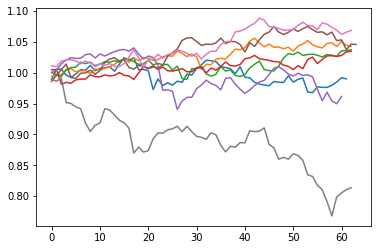

In [127]:
for each in tracked_all_ret:
    plt.plot(each.cumprod());

# Strategy results
The correction in late 2018 wiped out all gains. We had a negative return for the 2 year holding period. Not good.

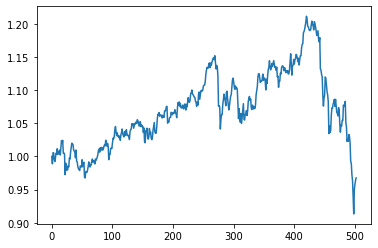

In [128]:
plt.plot(joined_trading_returns.cumprod());

# Compare this trading strategy with a benchmark
Given the absurd nature of this strategy its hard to say if it should be benchmarked at all...

In [129]:
print("Getting Russell 3000 data")
df_rua = pdr.get_data_yahoo('^RUA', '2017', '2019', interval = 'd')
df_rua = df_rua['Adj Close']
df_rua = pd.DataFrame(df_rua)
print("Done!")
df_rua_log_returns = np.log(df_rua / df_rua.shift(1))
df_rua_log_returns.fillna(0, inplace = True)
df_rua_log_returns += 1
rua_log_returns = np.array(df_rua_log_returns)
print("Ready to plot")

Getting Russell 3000 data
Done!
Ready to plot


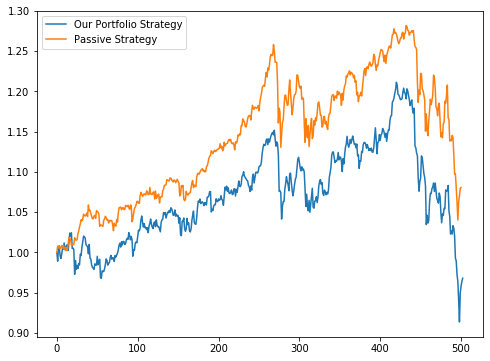

In [130]:
plt.figure(figsize = (8,6))
plt.plot(joined_trading_returns.cumprod(),  label = 'Our Portfolio Strategy');
plt.plot(rua_log_returns.cumprod(), label = 'Passive Strategy');
plt.legend(('Our Portfolio Strategy', 'Passive Strategy'), loc = 'upper left');

# Results
It's not suprising that our portfolio tended to follow the Russell 3000. Consider that large caps do impact the Russell 3000's performance and by holding even a small number of these large cap stocks would be enough to have significant exposure to the market. Thus it takes away from small cap performance.

Clearly we could have done better by doing literally anything else. We are not suprised by this. Our portfolios poor performance doesn't even account for transaction costs, which will only widden the gap!

We note that our Q1 2017 performance followed a completely different direction than the Russell 3000. We suspect that this contributed the most to the gap and was hard to recover from.

#### Commentary:
The quarters for 2019 have been added here. They weren't in the original project but I figured it would be fun to see how the strategy has done since the start of the year

Getting Russell 3000 data
Done!
Ready to plot


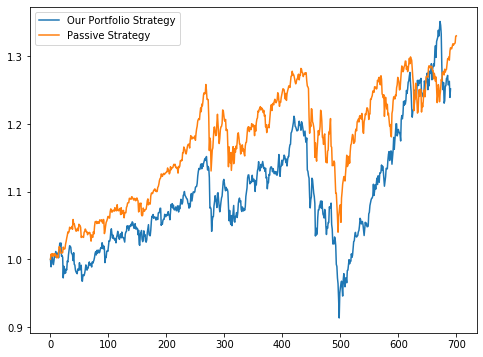

In [132]:
wght_q9 = portfolio_optimization(df_log_returns, '2016-12-31', '2018-12-31')
track_ret_q9 = tracked_returns(wght_q9, df_log_returns['2019-01':'2019-03'])
tracked_all_ret.append(track_ret_q9)
wght_q10 = portfolio_optimization(df_log_returns, '2017-03-31', '2019-03-31')
track_ret_q10 = tracked_returns(wght_q10, df_log_returns['2019-04':'2019-06'])
tracked_all_ret.append(track_ret_q10)
wght_q11 = portfolio_optimization(df_log_returns, '2017-06-30', '2019-06-30')
track_ret_q11 = tracked_returns(wght_q11, df_log_returns['2019-07':'2019-09'])
tracked_all_ret.append(track_ret_q11)

joined_trading_returns = np.array([1])
for track in tracked_all_ret:
    joined_trading_returns = np.append(joined_trading_returns, track)


print("Getting Russell 3000 data")
df_rua = pdr.get_data_yahoo('^RUA', '2017', '2020', interval = 'd')
df_rua = df_rua['Adj Close']
df_rua = pd.DataFrame(df_rua)
print("Done!")
df_rua_log_returns = np.log(df_rua / df_rua.shift(1))
df_rua_log_returns.fillna(0, inplace = True)
df_rua_log_returns += 1
rua_log_returns = np.array(df_rua_log_returns)
print("Ready to plot")

plt.figure(figsize = (8,6))
plt.plot(joined_trading_returns.cumprod(),  label = 'Our Portfolio Strategy');
plt.plot(rua_log_returns.cumprod(), label = 'Passive Strategy');
plt.legend(('Our Portfolio Strategy', 'Passive Strategy'), loc = 'upper left');

# hmm... interesting.